# Lab 3: Document Classification (Part 2)

### Overview
This topic builds on the activities of the previous topic on sentiment analysis. You will be focussing on the movie review corpus with a view to investigating the following issues.

- Evaluation metrics for classifier performance
- What is the impact of varying training data size? To what extent does increasing the quantity of training data improve classifier performance?

By this stage, you should be very comfortable with Python's [list comprehensions](http://docs.python.org/tutorial/datastructures.html#list-comprehensions) and [slice](http://bergbom.blogspot.co.uk/2011/04/python-slice-notation.html) notation.



>To access functionality defined in previous notebooks, copy the functions defined in Week3Labs into a `utils.py` file and then import it into the notebook.  There is a `utils.py` file included with these resources which you can update.

In [ ]:
##uncomment the following lines on colab

from google.colab import drive
drive.mount('/content/drive')

In [2]:
#other needed imports
from nltk.corpus import movie_reviews
import random
import pandas as pd
#this next line will ensure pandas graphs are plotted in the notebook
%matplotlib inline  

##download stopwords and movie_reviews - need to do this every session on colab
import nltk
nltk.download('stopwords')
nltk.download('movie_reviews')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kerimciger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/kerimciger/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [14]:
#set your system path so that jupyter knows where to look for other files
#import sys
#sys.path.append('/content/drive/My Drive/NLE Notebooks 2021/Week3LabsSolutions/')
#import code to setup training and testing data, wordlist classifiers and NB classifiers
from utils import *



In [4]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Evaluation Metrics for Classifier Performance

### Accuracy
Here is code for an evaluation function <code>evaluate_wordlist_classifier</code> which can be used to determine how well a word_list classifier performs. This function returns the <b>accuracy</b> of a classifier. The accuracy metric is defined as the proportion of documents that were correctly classified.  Look at the code and make sure you understand what it is doing

In [8]:
def classifier_evaluate(cls, test_data):
    '''
    cls: an instance of a classifier object which has a classify method which returns "pos" or "neg"
    test_data: a list of pairs where each pair is a FreqDist rep of a doc and its label
  
    returns: float point number which is the accuracy of the classifier on the test data provided 
    '''
    acc = 0
    docs,goldstandard=zip(*test_data) #note this neat pythonic way of turning a list of pairs into a pair of lists
    #pass all of the docs to the classifier and get back a list of predictions
    predictions=cls.classify_many(docs)
    #zip the predictions with the goldstandard labels and compare
    for prediction,goldlabel in zip(predictions,goldstandard):
        if prediction==goldlabel:
            acc+=1
    
    return acc / (len(test_data))

Now we need some data to train and test our classifier on.  We are going to make use of the code from the lab_3_1.  

In [5]:
def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
    #now normalise and create bag-of-words FreqDist representations
    training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training]
    testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing]
    return training_norm, testing_norm

In [6]:
random.seed(41)  #set the random seeds so these random splits are always the same
training,testing=get_train_test_data()

training[0]

(FreqDist({',': 24, '.': 18, 'and': 11, 'a': 9, 'to': 8, 'the': 7, 'melvin': 6, 'his': 6, "'": 6, 's': 6, ...}),
 'pos')

We are now going to use this function to start evaluating our classifiers from last week.  Lets first try the SimpleClassifier

In [9]:
#here I am going to create an instance of a very simple classifier 

my_positive_word_list = ["good","great","lovely", "excellent"] # extend this one or put your own list here
my_negative_word_list = ["bad", "terrible", "awful", "dreadful"] # extend this one or put your own list here
movie_classifier1 = SimpleClassifier(my_positive_word_list,my_negative_word_list)

#Evaluate classifier
#The function requires two arguments:
# 1. Word list based classifer
# 2. A list (or generator) of labelled test items
score = classifier_evaluate(movie_classifier1, testing)  
print(score)

0.5


In [11]:
docs,labels=zip(*testing)
preds=movie_classifier1.classify_many(docs)

len( preds )

600

If you have run the cell above without updating the SimpleClassifier code you should see that the accuracy is 0.5 i.e., 50%. The original SimpleClassifier just assigns everything to the positive class.  Since it is a binary classification decision and the classes are balanced, it will get 50% of the decisions correct (those that are positive) and 50% of the decisions incorrect (those that are actually negative).  This is the **baseline** result for this kind of classification task.  We obviously want to build classifiers that do better than this.

In [9]:
preds

['pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',


### Exercise 1

Now you try one of the classifiers that you wrote that selects positive and negative words from the training data.  Hopefully, this will perform better than the baseline of 50%. 

In [15]:
#Create a new classifier
#Make sure you have updated the code in utils.py to contain your WordList Classifier
#If you update the utils.py code mid-session, you will need to restart the runtime / kernel in order to force it to import the new updated code
movie_classifier2 = SimpleClassifier_mf(100)
#train it
movie_classifier2.train(training)
#evaluate it on the test data
score=classifier_evaluate(movie_classifier2,testing)
print(score)

AttributeError: 'SimpleClassifier_mf' object has no attribute 'train'

## Precision, Recall and F1 score etc

When classes are unbalanced, evaluating classifiers in terms of accuracy can be misleading.  For example, if 10% of documents are relevant and 90% of documents are irrelevant, then a classifier which labels all documents as irrelevant will obtain an accuracy of 90%.  This sounds good but is actually useless. More useful metrics for evaluation of performance are precision, recall and F1 score.  These metrics allow us to distinguish the different types of errors our classifiers make.

For each class, $c$, we need to keep a record of 
* True Positives: $TP=|\{i|\mbox{prediction}(i)=\mbox{label}(i)=c\}|$
* False Negatives: $FN=|\{i|\mbox{prediction}(i)\neq \mbox{label}(i)=c\}|$
* False Positives: $FP=|\{i|\mbox{label}(i) \neq \mbox{prediction}(i)=c\}|$
* True Negatives: $TN=|\{i|\mbox{prediction}(i)=\mbox{label}(i)\neq c\}|$

Note the symmetry in the binary classification task (the TN for one class are the TP for the other class and so on).  Therefore, in binary classification, we just record these values and compute the following evaluation metrics for a single class (e.g. "Relevant" or "Positive")

* Precision: 
\begin{eqnarray*}
P=\frac{TP}{TP+FP}
\end{eqnarray*}
* Recall: 
\begin{eqnarray*}
R=\frac{TP}{TP+FN}
\end{eqnarray*}
* F1-score: 
\begin{eqnarray*}
F1 = \frac{2\times P\times R}{P+R}
\end{eqnarray*}


 ### Exercise 2.1
 
 The code below defines a ConfusionMatrix class for the binary classification task.  Currently, it will compute the number of TPs, FPs, FNs and TNs.  Test it out with predictions and test data for our sentiment analysis task.

In [11]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):
    
        (self.c1,self.c2)=classes
        #self.predictions=predictions
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
        
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
        
    
    def precision(self):
        p=0
        #put your code to compute precision here
        p = self.TP / (self.TP + self.FP)
    
        return p
  
    def recall(self):
        r=0
        #put your code to compute recall here
    
        return r
  
    def f1(self):
        f1=0
        #put your code to compute f1 here
        p=self.precision()
        r=self.recall()
        f1=p*r/()
        return f1 

In [12]:
mystring="fred"
mystring.isalpha()

True

In [13]:
#docs will contain the documents to classify, labels contains the corresponding gold standard labels
docs,labels=zip(*testing)
senti_cm=ConfusionMatrix(movie_classifier1.classify_many(docs),labels)
print(senti_cm.TP)
print(senti_cm.FP)
print(senti_cm.TN)
print(senti_cm.FN)

281
205
95
19


In [14]:
list(labels)

['pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',


In [15]:
senti_cm.precision()

0.5781893004115226

### Exercise 2.2
* Add functionality to the ConfusionMatrix class code to compute precision, recall and F1 score
* Use your code to evaluate the performance of the different classifiers you have constructed.
* Interpret your results

## Investigating the impact of the quantity of training data
We will begin by exploring the impact on classification accuracy of using different quantities of training data.




Run the code in the cell below several times.  Each time it should generate a new sample of review data, train the classifiers and evaluate them.

The accuracy of Word List MF classifier is 0.6016666666666667
The accuracy of Word List Thresh classifier is 0.49833333333333335


,0,1
0,Word List MF,0.601667
1,Word List Thresh,0.498333


(0.0, 1.0)

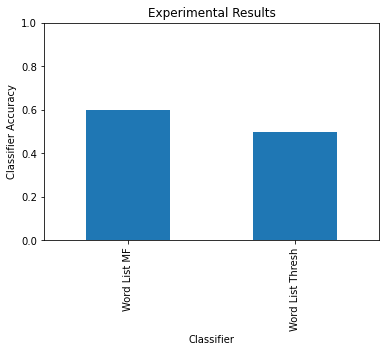

In [17]:

training,testing=get_train_test_data()

word_list_size = 100
threshold=100
classifiers={"Word List MF":SimpleClassifier_mf(word_list_size),
             "Word List Thresh":SimpleClassifier_ot(threshold)}

results=[]
for name,classifier in classifiers.items():
    classifier.train(training)
    accuracy=classifier_evaluate(classifier,testing)
    print("The accuracy of {} classifier is {}".format(name,accuracy))
    results.append((name,accuracy))
             
df = pd.DataFrame(results)
display(df)
ax = df.plot.bar(title="Experimental Results",legend=False,x=0)
ax.set_ylabel("Classifier Accuracy")
ax.set_xlabel("Classifier")
ax.set_ylim(0,1.0)

As you can see, the classifiers have different accuracies on different runs. 

### Exercise 3.1
Copy the cell above and move the copy to be positioned below this cell. Then adapt the code so that the accuracy reported for each classifier is the average across multiple runs.

The accuracy of Word List MF classifier is 0.6266666666666667
The accuracy of Word List Thresh classifier is 0.555
The accuracy of Word List MF classifier is 0.645
The accuracy of Word List Thresh classifier is 0.555
The accuracy of Word List MF classifier is 0.6533333333333333
The accuracy of Word List Thresh classifier is 0.5316666666666666


,0,1
0,Word List MF,0.641667
1,Word List Thresh,0.547222


(0.0, 1.0)

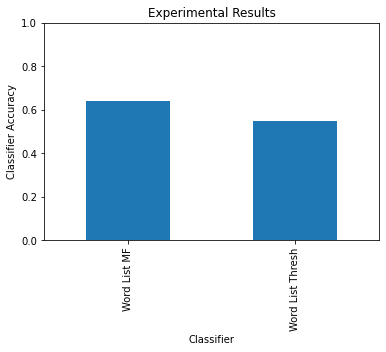

In [18]:
word_list_size = 100
threshold=100
classifiers={"Word List MF":SimpleClassifier_mf(word_list_size),
             "Word List Thresh":SimpleClassifier_ot(threshold)}

number_of_runs=3

results={}
for key in classifiers.keys():

    results[key]=0

for i in range(number_of_runs):
    training,testing=get_train_test_data()
    for name,classifier in classifiers.items():
        classifier.train(training)
        accuracy=classifier_evaluate(classifier,testing)
        print("The accuracy of {} classifier is {}".format(name,accuracy))
        results[name]=results[name]+(accuracy/number_of_runs)
             
df = pd.DataFrame(list(results.items()))
display(df)
ax = df.plot.bar(title="Experimental Results",legend=False,x=0)
ax.set_ylabel("Classifier Accuracy")
ax.set_xlabel("Classifier")
ax.set_ylim(0,1.0)

### Exercise 3.2
Adapt the code so that it calculates average precision, recall and F1-score rather than average accuracy.

The precision of Word List MF classifier is 0.6431818181818182
The precision of Word List Thresh classifier is 0.5316455696202531
The precision of Word List MF classifier is 0.5785288270377733
The precision of Word List Thresh classifier is 0.5212014134275619
The precision of Word List MF classifier is 0.5756972111553785
The precision of Word List Thresh classifier is 0.5202108963093146


,0,1
0,Word List MF,0.599136
1,Word List Thresh,0.524353


(0.0, 1.0)

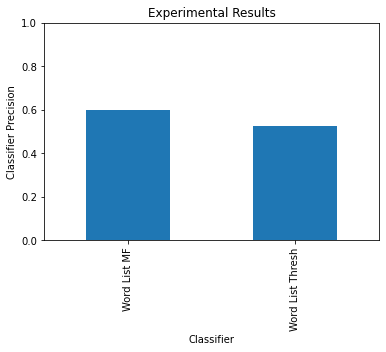

In [19]:
word_list_size = 100
threshold=100
classifiers={"Word List MF":SimpleClassifier_mf(word_list_size),
             "Word List Thresh":SimpleClassifier_ot(threshold)}

number_of_runs=3

results={}
for key in classifiers.keys():

    results[key]=0

for i in range(number_of_runs):
    training,testing=get_train_test_data()
    docs,labels=zip(*testing)
    for name,classifier in classifiers.items():
        classifier.train(training)
        senti_cm=ConfusionMatrix(classifier.classify_many(docs),labels)   
        print("The precision of {} classifier is {}".format(name,senti_cm.precision()))
        #I have only done precision here but you should do recall and F1 as well
        results[name]=results[name]+(senti_cm.precision()/number_of_runs)
             
df = pd.DataFrame(list(results.items()))
display(df)
ax = df.plot.bar(title="Experimental Results",legend=False,x=0)
ax.set_ylabel("Classifier Precision")
ax.set_xlabel("Classifier")
ax.set_ylim(0,1.0)

### Exercise 3.3
Investigate the impact of training data size on the performance of both word list classifiers, using a range of subsets of movie reviews.

Hints and tips.
- You can copy the code cell that you created for the last exercise, and place the copy below this cell. Then adapt the code to determine accuracy, precision, recall and F1-score for each classifier on each subset.

- Use the `sample` function from the random module. 
- Remember, the full data set has 1000 positive and 1000 negative reviews. 
- You should continue to use 30% of the data for testing, so this means that we have up to 700 positive and 700 negative reviews to sample from.
- Make sure that you are selecting samples that have an equal number of positive and negative reviews.
- Consider (at least) the following sample sizes: 2, 10, 50, 100, 200, 400, 600 and 700.
- Note that the sample size is not the total number of reviews, but the number of positive reviews (which is also equal to the number of negative reviews).


**Interpret your results**

In [20]:
from random import sample

sample_sizes=[2,10,50,100,200,400,600, 700]
results={}


for size in sample_sizes:
    res={}

    for i in range(number_of_runs):
        training,testing=get_train_test_data()
        
        positive_training=[(doc,label) for (doc,label) in training if label=="pos"]
        negative_training=[(doc,label) for (doc,label) in training if label=="neg"]
        training_sample=sample(positive_training,size)+sample(negative_training,size)
        for name,classifier in classifiers.items():
      
            classifier.train(training_sample)
            accuracy=classifier_evaluate(classifier,testing)
            #print("The accuracy of {} classifier with training sample size {} is {}".format(name,size, accuracy))
            res[name]=res.get(name,0)+accuracy/number_of_runs
    results[size]=res

    
results


{2: {'Word List MF': 0.5416666666666666, 'Word List Thresh': 0.5},
 10: {'Word List MF': 0.5366666666666666, 'Word List Thresh': 0.5},
 50: {'Word List MF': 0.6172222222222222, 'Word List Thresh': 0.5},
 100: {'Word List MF': 0.5922222222222222, 'Word List Thresh': 0.5},
 200: {'Word List MF': 0.5883333333333334,
  'Word List Thresh': 0.5388888888888889},
 400: {'Word List MF': 0.6583333333333333,
  'Word List Thresh': 0.5616666666666666},
 600: {'Word List MF': 0.633888888888889,
  'Word List Thresh': 0.5677777777777778},
 700: {'Word List MF': 0.6516666666666666,
  'Word List Thresh': 0.5744444444444444}}

In [21]:
df=pd.DataFrame(results)
df=df.transpose()
df

,Word List MF,Word List Thresh
2,0.541667,0.500000
10,0.536667,0.500000
50,0.617222,0.500000
100,0.592222,0.500000
200,0.588333,0.538889
400,0.658333,0.561667
600,0.633889,0.567778
700,0.651667,0.574444


Text(0.5, 0, 'Sample Size')

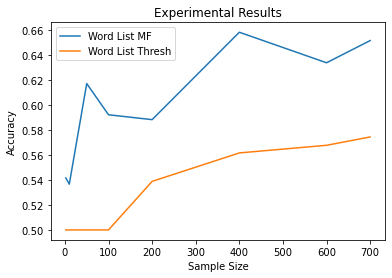

In [22]:
ax = df.plot(kind="line",title="Experimental Results")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Sample Size")

My answer

From the graph I can see that increasing the amount of training data generally seems to help up until a certain point (sample size around 200).  After this point, performance even seems to go down.  The wordlist classifier with 100 most frequent words appears to outperform the wordlist classifier where frequency difference is greater than 100, for all sample sizes.  Around 200, there is a massive fluctuation in the results for the most frequent word classifier which is presumably caused by a certain word(s) being in or out of the list at this point (which is suggesting we are over-fitting the test set).